# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7); # 1D vector of random numbers, uniform on [0,1)

In [2]:
sum(a)

5.0005494633404855e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.006581 seconds (5 allocations: 176 bytes)


5.0005494633404855e6

In [4]:
@time sum(a)

  0.006563 seconds (5 allocations: 176 bytes)


5.0005494633404855e6

In [5]:
@time sum(a)

  0.006476 seconds (5 allocations: 176 bytes)


5.0005494633404855e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [6]:
# using Pkg
# Pkg.add("BenchmarkTools")

In [7]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [8]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -std=gnu99 -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [9]:
c_sum(a)

5.000549463341633e6

In [10]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [11]:
c_sum(a) - sum(a)  

1.1473894119262695e-6

In [12]:
≈  # alias for the `isapprox` function

isapprox (generic function with 8 methods)

In [13]:
?isapprox

search: isapprox



```
isapprox(x, y; rtol::Real=atol>0 ? 0 : √eps, atol::Real=0, nans::Bool=false, norm::Function)
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

`x` and `y` may also be arrays of numbers, in which case `norm` defaults to `vecnorm` but may be changed by passing a `norm::Function` keyword argument. (For numbers, `norm` is the same thing as `abs`.) When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```


We can now benchmark the C code directly from Julia:

In [14]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     13.560 ms (0.00% GC)
  median time:      13.604 ms (0.00% GC)
  mean time:        13.636 ms (0.00% GC)
  maximum time:     15.157 ms (0.00% GC)
  --------------
  samples:          367
  evals/sample:     1

In [15]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 13.560436 msec


In [16]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any,Any} with 1 entry:
  "C" => 13.5604

In [17]:
using Plots
gr()

Plots.GRBackend()

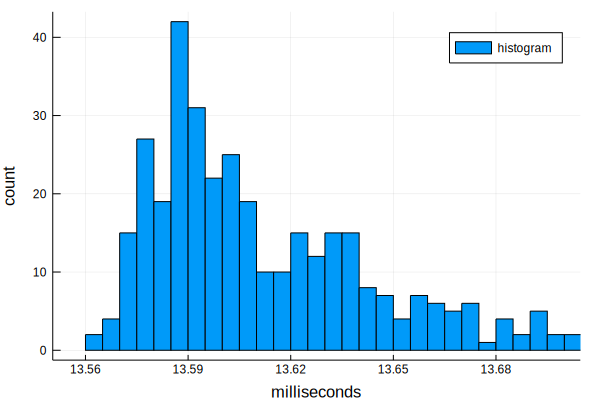

In [18]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="histogram")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [19]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -std=gnu99 -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [20]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     7.399 ms (0.00% GC)
  median time:      7.458 ms (0.00% GC)
  mean time:        7.497 ms (0.00% GC)
  maximum time:     7.757 ms (0.00% GC)
  --------------
  samples:          667
  evals/sample:     1

In [21]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

7.398784

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [22]:
# using Pkg; Pkg.add("PyCall")
using PyCall

In [23]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [24]:
pysum(a)

5.000549463341633e6

In [25]:
pysum(a) ≈ sum(a)

true

In [26]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 
  memory estimate:  368 bytes
  allocs estimate:  8
  --------------
  minimum time:     1.120 s (0.00% GC)
  median time:      1.122 s (0.00% GC)
  mean time:        1.121 s (0.00% GC)
  maximum time:     1.122 s (0.00% GC)
  --------------
  samples:          5
  evals/sample:     1

In [27]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any,Any} with 3 entries:
  "C"               => 13.5604
  "Python built-in" => 1119.75
  "C -ffast-math"   => 7.39878

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [28]:
# using Pkg; Pkg.add("Conda")
using Conda

In [29]:
# Conda.add("numpy")

In [30]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at In[30]:1
└ @ Core In[30]:1


BenchmarkTools.Trial: 
  memory estimate:  368 bytes
  allocs estimate:  8
  --------------
  minimum time:     6.641 ms (0.00% GC)
  median time:      6.683 ms (0.00% GC)
  mean time:        6.689 ms (0.00% GC)
  maximum time:     7.512 ms (0.00% GC)
  --------------
  samples:          747
  evals/sample:     1

In [31]:
numpy_sum(a)

5.000549463340483e6

In [32]:
numpy_sum(a) ≈ sum(a)

true

In [33]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"               => 13.5604
  "Python numpy"    => 6.64108
  "Python built-in" => 1119.75
  "C -ffast-math"   => 7.39878

# 5. Python, hand-written 

In [34]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7fa813e5e500>

In [35]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 
  memory estimate:  368 bytes
  allocs estimate:  8
  --------------
  minimum time:     1.427 s (0.00% GC)
  median time:      1.428 s (0.00% GC)
  mean time:        1.428 s (0.00% GC)
  maximum time:     1.429 s (0.00% GC)
  --------------
  samples:          4
  evals/sample:     1

In [36]:
sum_py(a)

5.000549463341633e6

In [37]:
sum_py(a) ≈ sum(a)

true

In [38]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any,Any} with 5 entries:
  "C"                   => 13.5604
  "Python numpy"        => 6.64108
  "Python hand-written" => 1426.95
  "Python built-in"     => 1119.75
  "C -ffast-math"       => 7.39878

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [39]:
@which sum(a)

sum(a::AbstractArray) in Base at reducedim.jl:648

In [40]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     6.384 ms (0.00% GC)
  median time:      6.404 ms (0.00% GC)
  mean time:        6.411 ms (0.00% GC)
  maximum time:     6.780 ms (0.00% GC)
  --------------
  samples:          779
  evals/sample:     1

In [41]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any,Any} with 6 entries:
  "C"                   => 13.5604
  "Python numpy"        => 6.64108
  "Python hand-written" => 1426.95
  "Python built-in"     => 1119.75
  "Julia built-in"      => 6.38437
  "C -ffast-math"       => 7.39878

# 7. Julia (hand-written) 

In [42]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [43]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     13.626 ms (0.00% GC)
  median time:      13.660 ms (0.00% GC)
  mean time:        13.663 ms (0.00% GC)
  maximum time:     13.736 ms (0.00% GC)
  --------------
  samples:          366
  evals/sample:     1

In [44]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 7 entries:
  "C"                   => 13.5604
  "Python numpy"        => 6.64108
  "Julia hand-written"  => 13.6264
  "Python hand-written" => 1426.95
  "Python built-in"     => 1119.75
  "Julia built-in"      => 6.38437
  "C -ffast-math"       => 7.39878

# 8. Julia (hand-written w. simd) 

In [45]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [46]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     6.378 ms (0.00% GC)
  median time:      6.398 ms (0.00% GC)
  mean time:        6.403 ms (0.00% GC)
  maximum time:     6.747 ms (0.00% GC)
  --------------
  samples:          780
  evals/sample:     1

In [47]:
mysum_simd(a)

5.000549463340452e6

In [48]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any,Any} with 8 entries:
  "Julia hand-written simd" => 6.37797
  "C"                       => 13.5604
  "Python numpy"            => 6.64108
  "Julia hand-written"      => 13.6264
  "Python hand-written"     => 1426.95
  "Python built-in"         => 1119.75
  "Julia built-in"          => 6.38437
  "C -ffast-math"           => 7.39878

# Summary

In [49]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Julia hand-written simd.....6.4
Julia built-in..............6.4
Python numpy................6.6
C -ffast-math...............7.4
C..........................13.6
Julia hand-written.........13.6
Python built-in..........1119.8
Python hand-written......1427.0
